# DAY 59 · 经典时序模型（3）：SARIMA 与多变量时序概览

**本节目标**
- 理解 `SARIMA(p,d,q)(P,D,Q,m)` 为什么能统一处理“趋势 + 季节性”。
- 掌握一套可复用的 SARIMA 实战流程：`观察 → 定 m → 定 d/D → 定 p/q/P/Q → 拟合 → 诊断 → 预测`。
- 建立对多变量时序的整体认识：经典统计（SARIMAX/VAR）、机器学习（滑动窗口）、深度学习（序列模型）。

**本节关键词**：季节性（seasonality）、季节差分（D）、周期 `m`、ACF/PACF、AIC、模型诊断图、外生变量（exogenous）

在之前的学习中，我们已经按时间序列经典模型的脉络走了一遍：

- **AR**：用过去的值解释当前值
- **MA**：用过去的误差解释当前值
- **ARMA**：AR + MA
- **ARIMA**：在 ARMA 上加入差分（`d`）以处理非平稳（趋势）

昨天我们还提到：当数据存在**明显季节性**时，可以做**季节差分**来消除季节波动。

如果把“季节差分 + 季节结构”也**合并进模型**，让处理流程更统一，就得到今天的主角：**SARIMA**（Seasonal ARIMA）。

# 一、SARIMA 模型

SARIMA（Seasonal AutoRegressive Integrated Moving Average）是标准 ARIMA 的扩展，专门用于处理具有明显季节性模式的时间序列。

你可以把 SARIMA 想象成一个“双核”的 ARIMA：

1. **非季节性核心**：处理整体趋势与短期相关（跟 ARIMA 一样）。
2. **季节性核心**：处理每隔 `m` 个时间点重复一次的周期模式（例如月度数据的年度周期 `m=12`）。

它解决的关键问题是：
- **趋势**：通过普通差分 `d` 让序列更平稳
- **季节性**：通过季节差分 `D`（间隔 `m`）以及季节 AR/MA（`P/Q`）捕捉周期结构

## 1.1 SARIMA 模型的参数

SARIMA 由两组参数共同定义：

- **非季节性部分**：`(p, d, q)`（与 ARIMA 完全一致）
- **季节性部分**：`(P, D, Q, m)`（注意大小写）

标准写法：`SARIMA(p,d,q)(P,D,Q,m)`，很多文献也写成 `SARIMA(p,d,q)(P,D,Q)_m`。

为什么把 `m` 单独拎出来？因为它不是“拟合出来的阶数”，而是数据的结构属性：它告诉模型**季节周期的长度**。

### 把 `m` 理解成“舞台”，把 `P/D/Q` 理解成“演员”

- `m`：季节性周期（舞台多大）
  - 月度数据的年度季节性：`m=12`
  - 季度数据的年度季节性：`m=4`
  - 日度数据的周季节性：`m=7`

- `P, D, Q`：在这个季节尺度上，模型要做什么（演员怎么演）

| 符号 | 直觉问题 | 典型形式（以季节周期 m 为步长） |
|---|---|---|
| `P` | 要看过去几个“同季节时刻”的自己？ | `y_{t-m}, y_{t-2m}, ...` |
| `D` | 要做几次季节差分来去掉季节性？ | `y_t - y_{t-m}` |
| `Q` | 要看过去几个“同季节时刻”的误差？ | `e_{t-m}, e_{t-2m}, ...` |

实践中：`m` 往往靠数据频率 + 业务常识直接确定；`P/D/Q` 常结合 ACF/PACF 或自动调参得到。

### (p,d,q) 与 (P,D,Q) 的核心区别

它们看的是**不同的滞后尺度**：

- 普通差分 `d`：\(y_t - y_{t-1}\)（今天 - 昨天）
- 季节差分 `D`：\(y_t - y_{t-m}\)（今年 8 月 - 去年 8 月）

同理：
- 普通 AR(`p`)：关注 `y_{t-1}, y_{t-2}, ...`
- 季节 AR(`P`)：关注 `y_{t-m}, y_{t-2m}, ...`
- 普通 MA(`q`)：关注 `e_{t-1}, e_{t-2}, ...`
- 季节 MA(`Q`)：关注 `e_{t-m}, e_{t-2m}, ...`

直觉一句话：**季节性阶数是在“跨季节的同一时刻”上做建模。**

普通 AR（`p`）认为当前值与最近几个时间点的历史值相关；

季节 AR（`P`）认为当前值与**上一个/上几个季节的同一时刻**相关：例如“今年 8 月用电量”与“去年 8 月、前年 8 月”直接相关。

普通 MA（`q`）认为当前值的预测误差与最近几个时间点的误差相关；

季节 MA（`Q`）认为当前值的预测误差与**上一个/上几个季节同一时刻**的误差相关：例如“今年 8 月预测误差”可以参考“去年 8 月、前年 8 月”的预测误差来修正。

**小结**：季节性部分不是“再做一次差分”这么简单；它是一套完整的季节尺度建模机制。

## 1.2 SARIMA 模型的理解

很多同学会把 SARIMA 理解成“ARIMA + 一次季节差分”，但更准确的理解是：

> SARIMA 在非季节性系统 `(p,d,q)` 之外，**并行**构建了一套完整的季节性系统 `(P,D,Q,m)`。

可以把它看成两层协同工作：

1. **季节性层面（Seasonal）**：
   - 先做季节差分 `D`（间隔 `m`）
   - 用季节 AR(`P`) / 季节 MA(`Q`) 去解释“季节差分后”的规律
   - 产出：季节性信息被解释后的残差序列

2. **非季节性层面（Non-seasonal）**：
   - 对残差序列做普通差分 `d`
   - 用 AR(`p`) / MA(`q`) 捕捉剩余的短期波动与非季节相关

**总结**：SARIMA 不是在 ARIMA 上打补丁，而是“季节系统 + 非季节系统”两套机制共同完成建模：
- 季节系统负责宏观的周期规律
- 非季节系统负责微观的短期波动

## 1.3 SARIMA 实战（以航空乘客数据为例）

### 1.3.1 数据观察

In [1]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings('ignore')

# 让 matplotlib 正常显示中文（如果你的环境缺少中文字体，这里可能需要自行安装字体）
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 1) 加载数据
# 本例使用经典的 Airline Passengers 数据集。
# - 若你能联网：直接从 GitHub raw 地址读取
# - 若你离线：请先把 airline-passengers.csv 下载到当前目录，再走本地读取
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
local_csv = Path('airline-passengers.csv')

if local_csv.exists():
    df = pd.read_csv(local_csv, header=0, index_col=0, parse_dates=True)
else:
    df = pd.read_csv(url, header=0, index_col=0, parse_dates=True)

# 统一列名，方便后续引用
df.columns = ['Passengers']

# 2) 划分训练集和测试集（保留最后 12 个月作为测试）
train_data = df.iloc[:-12]
test_data = df.iloc[-12:]

print('--- 训练集（最后 5 行）---')
print(train_data.tail())
print('--- 测试集（前 5 行）---')
print(test_data.head())


--- 训练集（最后 5 行）---
            Passengers
Month                 
1959-08-01         559
1959-09-01         463
1959-10-01         407
1959-11-01         362
1959-12-01         405
--- 测试集（前 5 行）---
            Passengers
Month                 
1960-01-01         417
1960-02-01         391
1960-03-01         419
1960-04-01         461
1960-05-01         472


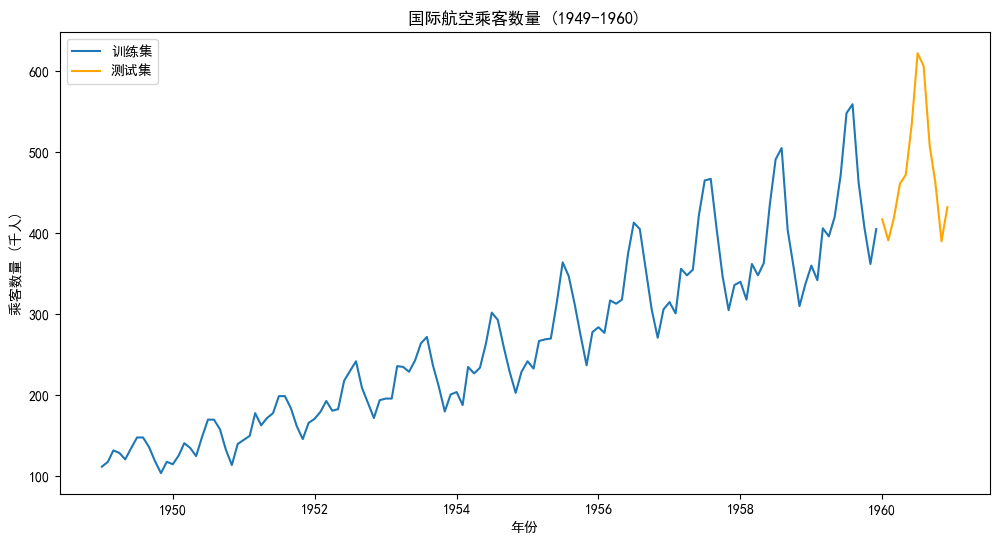

In [2]:
# 3) 可视化原始数据（先看趋势与季节性）
plt.figure(figsize=(12, 6))
plt.plot(train_data['Passengers'], label='训练集')
plt.plot(test_data['Passengers'], label='测试集', color='orange')
plt.title('国际航空乘客数量 (1949-1960)')
plt.xlabel('年份')
plt.ylabel('乘客数量 (千人)')
plt.legend()
plt.show()


从图中一般能直观看到两个特征：

1. **长期趋势（Trend）**：乘客数量整体随时间上升
2. **季节性（Seasonality）**：每年固定月份附近出现周期性波动（波峰/波谷）

因此：原序列 **非平稳**，并且季节性明显 —— 这正是 SARIMA 的典型应用场景。

### 1.3.2 尝试差分阶数

我们需要确定 SARIMA 参数 `（p,d,q）（P,D,Q,m）`，建议按这个顺序：

1. **先定季节周期 `m`**：
   - 数据是月度频率，季节模式是年度周期 → `m = 12`

2. **再定差分阶数 `D` 与 `d`**（目标：差分后序列更平稳）：
   - 先尝试季节差分：季节性明显 → `D = 1`
   - 若仍有趋势，再尝试普通差分：趋势明显 → `d = 1`

接下来做一次 `D=1, m=12` 的季节差分，再做一次 `d=1` 的普通差分，并用 **ADF 检验**验证平稳性。

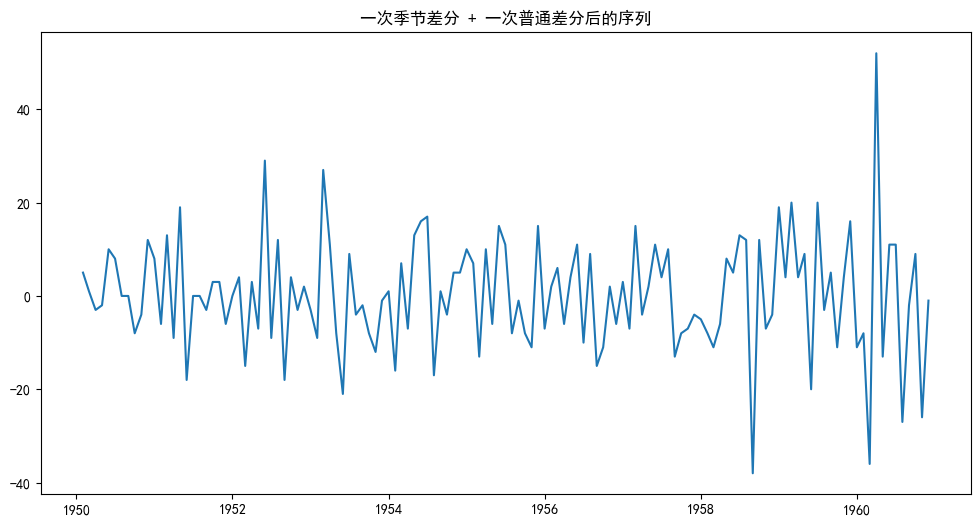

ADF Statistic: -15.5956
p-value: 0.000000


In [3]:
# 4) 差分：先季节差分（D），再普通差分（d）
# - 季节差分：间隔 m=12（今年同月 - 去年同月），用于去季节性
# - 普通差分：间隔 1（月），用于去趋势

m = 12

# 进行季节性差分 (D=1, m=12)
seasonal_diff = df['Passengers'].diff(m).dropna()

# 再进行普通差分 (d=1)
seasonal_and_regular_diff = seasonal_diff.diff(1).dropna()

# 绘制差分后的数据
plt.figure(figsize=(12, 6))
plt.plot(seasonal_and_regular_diff)
plt.title('一次季节差分 + 一次普通差分后的序列')
plt.show()

# 5) ADF 检验：p-value 越小，越倾向认为序列平稳
adf_stat, p_value, *_ = adfuller(seasonal_and_regular_diff)
print(f'ADF Statistic: {adf_stat:.4f}')
print(f'p-value: {p_value:.6f}')


观察差分后的序列：如果它围绕 0 上下波动、没有明显趋势/季节结构，通常说明差分有效。

ADF 检验中：
- `p-value < 0.05` 通常意味着可以拒绝“非平稳”的原假设（序列更接近平稳）

因此本例中：`d=1, D=1` 是一个合理的起点。

### 1.3.3 可视化确定其余参数

接下来要确定 AR/MA 的阶数：`(p,q)` 和 `(P,Q)`。

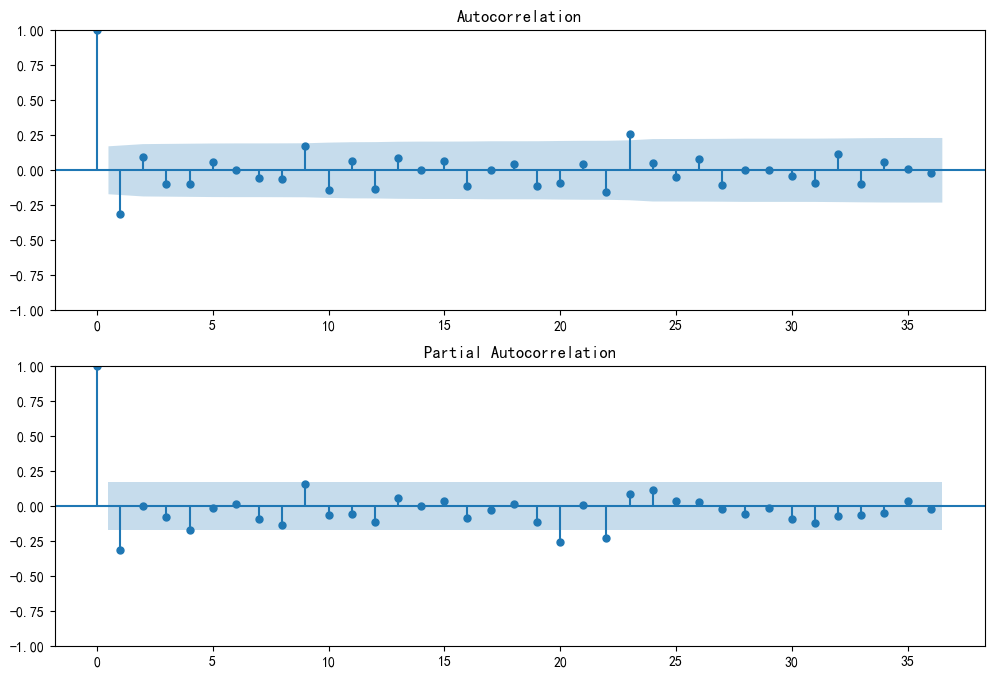

In [4]:
# 6) ACF/PACF：给 (p,q) 与 (P,Q) 一个“范围感”
# - 这里绘制到 36 阶：便于看到 12、24、36 这些季节滞后处是否有尖峰

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(seasonal_and_regular_diff, lags=36, ax=ax1)
plot_pacf(seasonal_and_regular_diff, lags=36, ax=ax2)
plt.show()


ACF/PACF 的经典用法是通过“截尾/拖尾”来判断阶数，但实战里确实容易混。

这里给一个更务实的建议：
- **把 ACF/PACF 当作“范围建议”**（比如 `p/q` 不要设太大；季节相关通常在 `m,2m,...` 处出现尖峰）
- 然后用自动搜索/网格搜索用 AIC/BIC 选最优

我们沿用昨天的原则：**AIC 越低通常越好**（在可比模型中）。

### 1.3.4 超参数搜索

In [5]:
# 7) 使用 auto_arima 自动搜索 (p,q,P,Q)（固定 d=1, D=1, m=12）
# 注意：pmdarima 不是 Python 标配库，如果缺失请先安装：pip install pmdarima

try:
    from pmdarima import auto_arima
except ImportError as e:
    raise ImportError('缺少 pmdarima：请先运行 `pip install pmdarima` 再执行本单元。') from e

auto_model = auto_arima(
    train_data['Passengers'],
    # 非季节部分搜索范围
    start_p=0, start_q=0,
    max_p=2, max_q=2,
    # 季节部分设置
    seasonal=True,
    m=12,
    start_P=0,
    # 固定差分阶数（来自前面分析）
    d=1,
    D=1,
    # 输出搜索过程，便于理解
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
)

print(auto_model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=905.419, Time=0.12 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=905.065, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=900.823, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=901.721, Time=0.06 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=899.902, Time=0.02 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=901.052, Time=0.05 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=901.337, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=900.971, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=900.685, Time=0.02 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=902.967, Time=0.07 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=901.457, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 0.777 seconds
                                     SARIMAX Results                                      


直接看 `auto_arima` 的搜索结果（以 AIC 为准）：

`Best model: ARIMA(1,1,0)(0,1,0)[12]`

解释一下这个结果：
- 非季节部分：`(p,d,q) = (1,1,0)`
- 季节部分：`(P,D,Q,m) = (0,1,0,12)`

接下来用 `statsmodels` 的 `SARIMAX`（不传外生变量时等价于 SARIMA）来拟合，并画诊断图。

### 1.3.5 模型诊断

除了结果表（参数显著性、AIC 等），论文/报告里更常用的是**模型诊断图**：

核心目标只有一个：
- 模型已经解释了可预测结构后，**残差应当像白噪声**（随机、无规律）。

best_order = (1, 1, 0)
best_seasonal_order = (0, 1, 0, 12)


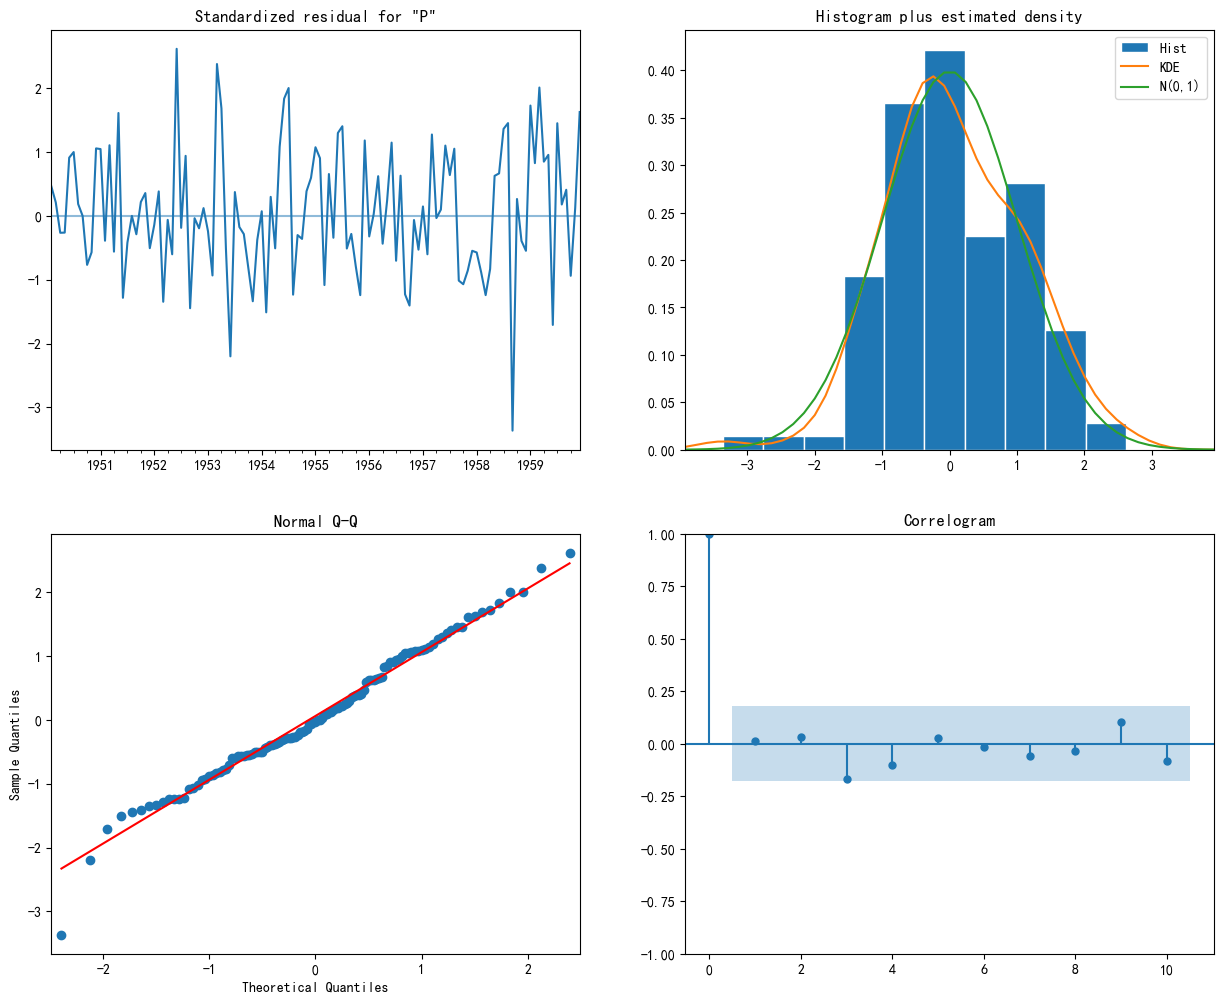

In [6]:
# 8) 用 statsmodels 拟合最优 SARIMA（SARIMAX 不传 exog 时等价 SARIMA）

best_order = auto_model.order
best_seasonal_order = auto_model.seasonal_order

print('best_order =', best_order)
print('best_seasonal_order =', best_seasonal_order)

model = SARIMAX(
    train_data['Passengers'],
    order=best_order,
    seasonal_order=best_seasonal_order,
)

results = model.fit(disp=False)

# 9) 诊断图：残差是否近似白噪声（论文里很常用）
results.plot_diagnostics(figsize=(15, 12))
plt.show()


`results.plot_diagnostics()` 通常会给出四张图，用来从不同角度验证“残差像白噪声”。

1) **标准化残差（随时间）**
- 期望：围绕 0 随机波动、方差相对稳定、没有明显结构

2) **残差直方图 + 密度曲线**
- 期望：大致接近正态分布（很多统计推断假设更希望残差近似正态）

3) **Q-Q 图**
- 期望：散点尽量贴近对角线（表示残差分布接近正态）

4) **残差 ACF（Correlogram）**
- 期望：除 `lag=0` 外，大多数柱子落在置信区间内（表示残差中不再存在显著自相关）

如果残差仍有明显自相关，通常意味着：
- `p/q` 或 `P/Q` 还不够
- 差分阶数 `d/D` 不合适
- 或者序列存在更复杂的结构（例如结构突变、外生冲击等）

### 1.3.6 结果预测

MAE:  18.528
RMSE: 23.932


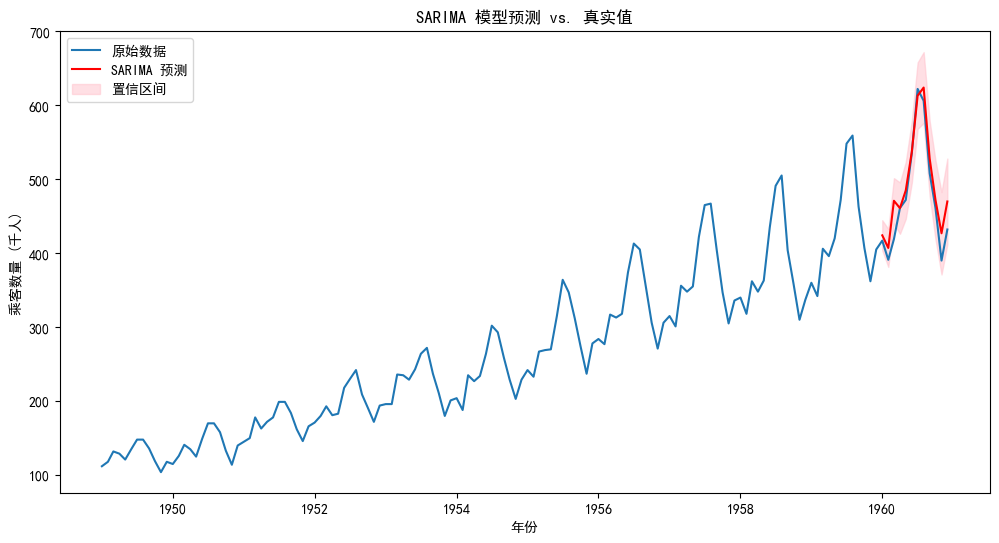

In [7]:
# 10) 在测试集区间做预测，并画出置信区间

predictions = results.get_prediction(start=test_data.index[0], end=test_data.index[-1])
pred_mean = predictions.predicted_mean
pred_ci = predictions.conf_int()

# 简单评估（不依赖 sklearn）
y_true = test_data['Passengers']
mae = np.mean(np.abs(y_true - pred_mean))
rmse = np.sqrt(np.mean((y_true - pred_mean) ** 2))
print(f'MAE:  {mae:.3f}')
print(f'RMSE: {rmse:.3f}')

plt.figure(figsize=(12, 6))
plt.plot(df['Passengers'], label='原始数据')
plt.plot(pred_mean, label='SARIMA 预测', color='red')

plt.fill_between(
    pred_ci.index,
    pred_ci.iloc[:, 0],
    pred_ci.iloc[:, 1],
    color='pink',
    alpha=0.5,
    label='置信区间',
)

plt.title('SARIMA 模型预测 vs. 真实值')
plt.xlabel('年份')
plt.ylabel('乘客数量 (千人)')
plt.legend()
plt.show()


如果红色预测线在测试集区间能紧跟真实值，且能对齐每年的波峰/波谷，通常说明：

- **趋势**捕捉得不错（非季节部分 + 差分）
- **季节性**捕捉得不错（季节差分 + 季节结构）

很多时序论文里会强调“捕捉到波峰和波谷”，本质上就是在说：

> 模型不仅预测了均值水平，还预测对了季节周期中的形状（相位与振幅）。

而季节性几乎是现实世界时序数据里最常见的结构之一。

# 二、多变量时序任务的理解

## 2.1 多变量数据

我们之前的航空乘客数据是**单变量**时序：每个时间点只有一个数值 \(y_t\)。

- 单变量示例：`[t1: y1], [t2: y2], ...`

多变量时序则是：每个时间点是一组数值（向量）\(\mathbf{y}_t\)。

- 多变量示例：`[t1: (y1, x1, z1)], [t2: (y2, x2, z2)], ...`

从数学对象上看：

- **单变量**：\(y_t\) 是标量（一个数字）
- **多变量**：\(\mathbf{y}_t\) 是向量（多个变量一起随时间变化）

多变量预测的难点在于：变量之间可能存在复杂的相关、因果、反馈回路。

## 2.2 常见的多变量预测模型

多变量时序预测方法可以粗分三类：

1. **经典统计模型**：结构清晰、解释性强，但假设较强
2. **机器学习模型**：把时序转成监督学习（滑动窗口），灵活但依赖特征工程
3. **深度学习模型**：端到端学习复杂模式，对数据量与训练资源要求更高

### 2.2.1 经典统计模型

#### SARIMAX：带外生变量的季节 ARIMA

SARIMAX（Seasonal ARIMA with eXogenous variables）里的 **X = eXogenous（外生变量）**。

如果说 SARIMA 是“双核”，那么 SARIMAX 可以理解成“三核”：

- 非季节性核心：`(p,d,q)`（趋势 + 短期相关）
- 季节性核心：`(P,D,Q,m)`（周期结构）
- 外部影响核心：`X`（量化外部变量对目标 `y` 的影响）

本质上可以把它看成：

> `SARIMAX = SARIMA + 线性回归项`

直观形式：
- ARIMA：\(y_t = f(	ext{过去的 } y, 	ext{过去的误差})\)
- SARIMAX：\(y_t = f(	ext{过去的 } y, 	ext{过去的误差}) + eta x_t\)

**优点**：解释性强（\(eta\) 的含义清晰），季节性处理成熟。

**关键限制（非常重要）**：
1. **单向因果假设**：默认是 `X → y`，不希望 `y` 反过来影响 `X`。
2. **预测时需要未来的 X**：要预测未来 \(y\)，通常必须提供未来 \(x\)（或你能先预测出未来 \(x\)）。

因此它更适合：因果方向明确、且未来 `X` 可获得/可预测的场景（如天气 → 销量）。

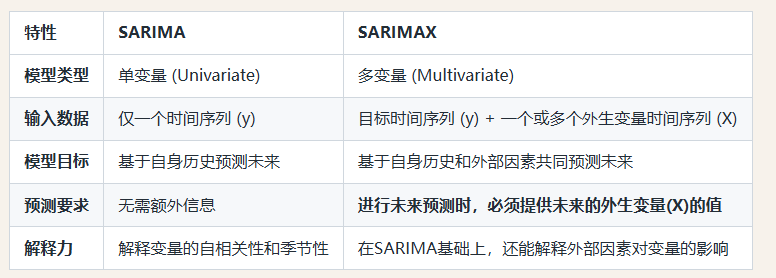

这里顺带强调一个常见误区：**相关 ≠ 因果**。

- 例子：冰淇淋销量与溺水人数正相关，但并不意味着“吃冰淇淋导致溺水”。
- 更合理的解释：它们共同受到第三变量“季节/气温”的影响。

很多机器学习解释方法（例如 SHAP）偏向相关贡献分解，并不直接解决因果问题，所以在需要“因果解释”的任务里要格外谨慎。

现实中还经常存在**双向依赖/循环依赖**（反馈回路）：

- 广告投入 `X` 会影响销售额 `y`，但销售额上涨又可能带来更高预算，从而反过来影响广告投入。
- 利率 `X` 影响通胀 `y`，但通胀水平又是央行调整利率的重要依据。

在这种场景下，强行指定 `X` 是外生、`y` 是内生并不合适。

为了解决“多变量相互影响”的问题，经典统计里常用 **VAR**（向量自回归）：
- 不区分内生/外生（或把多个变量都当作内生）
- 每个变量都由“系统内所有变量的过去值”共同预测
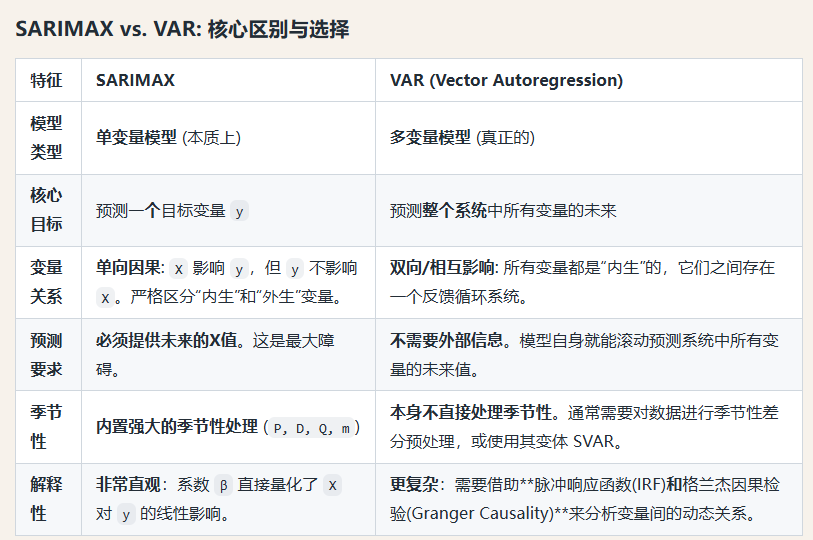

### 2.2.2 机器学习模型

这类方法通常用**滑动窗口**把时序问题转成表格化监督学习：

- 特征：滞后值（例如 `y_{t-1}, y_{t-2}, ...`），以及其他变量的滞后值（例如 `x_{t-1}`）
- 也常加：窗口统计特征（均值/方差/最大最小）、时间特征（星期几、月份等）
- 模型：XGBoost / LightGBM / RandomForest / 线性回归等

优点：
- 很强的非线性拟合能力（尤其是树模型）
- 不要求严格平稳假设

但依然强调：**特征工程很关键**。

论文里很常见的一种“混合思路”是：
- 用 SARIMA/SARIMAX 把趋势与季节性等线性结构先解释掉（当作特征提取器）
- 再把剩下的残差交给 XGBoost/LightGBM 去拟合非线性部分

直觉：统计模型“少数据也能做得不错”，深度/机器学习更需要数据；让两者分工常能提升效果。

### 2.2.3 深度学习模型

深度学习（LSTM/GRU/Transformer 等）可以在一定程度上绕开传统统计建模里繁琐的假设检验：

- 它更像一个通用的“函数拟合器”，直接从数据中学习趋势、季节性、自相关等模式
- 它不要求你必须先把趋势/季节性消掉；相反，这些都可以被当作可学习的特征

但这并不意味着传统分析没用：它依然能帮助你更快、更稳地训练出好模型。

同理：好的特征提取/统计分析，也能反过来帮助深度学习。

你可以把它理解成：给神经网络一些“先验提示”，减少试错成本。

#### 传统分析如何反哺深度学习（非常实用）

**1）ACF/PACF 帮你选 `sequence_length`（回看窗口）**
- ACF/PACF 提示“当前值与过去多少步还有显著关系”。
- 如果你看到明显的季节尖峰在 `m=12`，那么把 `sequence_length` 设为 `12` 或其倍数，往往是很好的起点。

**2）平稳性检验帮你做特征工程**
即使 LSTM 能学趋势，做一些简单处理也可能让训练更稳定：
- **差分**：让模型预测“变化量”，最后再还原成原尺度
- **显式时间特征**：月份/星期几/节假日等，明确告诉模型存在周期结构

**3）统计模型 + 深度学习 的分工（混合建模）**
一个常见范式是“先结构、后残差”：

```
原始数据 → [分解/统计建模] → 趋势(T) + 季节性(S) + 残差(R)
↓
分别建模/预测：T_hat, S_hat, R_hat
↓
最终预测：T_hat + S_hat + R_hat
```

直觉：
- 让“结构工程师”（分解/统计）先拿走确定的趋势与季节性
- 再让“精装修师傅”（机器学习/深度学习）去拟合更复杂的残差部分

# 三、课程收尾总结

## 心得总结

至此，训练营内容基本收束。

- 整体知识密度覆盖了复试课的大部分核心点（NLP、RNN 变体等来不及展开）。

一些心得：

1. **体系化比“知道怎么做”更重要**：很多问题如果只停留在“会用”，很容易在逻辑上出现断层；把原因讲清楚、把流程闭环串起来，才更可靠。
2. **学习需要持续堆时间**：哪怕是一个小的时序预测 demo，背后也有大量隐知识（为何与 ARIMA 对比、为何用 ARIMA 做特征工程、为何要诊断残差等）。工科很多时候没有捷径，只有持续实践与思考。